In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import xgboost
import lightgbm
import catboost
from catboost import CatBoostClassifier
from warnings import filterwarnings
import pickle
filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df_train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,1


### Checking data quality

In [4]:
df_train.isnull().any()

perc_premium_paid_by_cash_credit    False
age_in_days                         False
Income                              False
Count_3.6_months_late                True
Count_6.12_months_late               True
Count_more_than_12_months_late       True
application_underwriting_score       True
no_of_premiums_paid                 False
sourcing_channel                    False
residence_area_type                 False
premium                             False
renewal                             False
dtype: bool

In [5]:
np.where(df_train.apply(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [6]:
df_train.isnull().sum()

perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3.6_months_late                 64
Count_6.12_months_late                64
Count_more_than_12_months_late        64
application_underwriting_score      1976
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

### Making train, test and validation sets

In [7]:
X = df_train.drop('renewal', axis = 1)
y = df_train['renewal']

In [8]:
random_state = 2021
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state )
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [9]:
cat_features = ['sourcing_channel', 'residence_area_type']
model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=5, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)
pred = model.predict(X_test)
f1_score(pred, y_test, pos_label=0)

0:	learn: 0.5648330	test: 0.5631307	best: 0.5631307 (0)	total: 132ms	remaining: 4m 23s
100:	learn: 0.1749035	test: 0.1692258	best: 0.1692252 (99)	total: 9.38s	remaining: 2m 56s
200:	learn: 0.1677609	test: 0.1691093	best: 0.1687799 (136)	total: 19.2s	remaining: 2m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1687798688
bestIteration = 136

Shrink model to first 137 iterations.


0.2570951585976628

### Applying cross-validation

In [10]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)

    
    pred = model.predict(X_test)
    ff1.append(f1_score(y_test, pred, pos_label=0))
    

In [11]:
np.mean(ff1)

0.21087009142003915

In [12]:
model.best_iteration_

59

In [13]:
model.feature_importances_

array([22.62959856,  8.80481376,  5.83154523, 14.0766266 , 12.1729906 ,
        8.06408279,  9.53653114,  8.04974029,  4.17634859,  1.95510537,
        4.70261707])

In [14]:
  model.feature_names_

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3.6_months_late',
 'Count_6.12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'sourcing_channel',
 'residence_area_type',
 'premium']

In [15]:
X.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3.6_months_late', 'Count_6.12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium'],
      dtype='object')

### Detemining important features

In [16]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
importance = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
    
    imp = pd.DataFrame({'Importance': model.feature_importances_, 'Features': X.columns })
    importance.append(imp)   
    

In [17]:
importance[0]

,Importance,Features
0,23.867953,perc_premium_paid_by_cash_credit
1,10.834821,age_in_days
2,6.657610,Income
3,12.172279,Count_3.6_months_late
4,10.068025,Count_6.12_months_late
5,7.449410,Count_more_than_12_months_late
6,8.985434,application_underwriting_score
7,8.322320,no_of_premiums_paid
8,4.779199,sourcing_channel
9,2.426751,residence_area_type


In [18]:
len(importance)

5

In [19]:
tmp_df = pd.merge(importance[0], importance[1], left_on='Features', 
                  right_on='Features')[['Features', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance)):
    tmp_df = pd.merge(tmp_df, importance[i], left_on='Features', 
                      right_on='Features')

tmp_df['mean'] = tmp_df.mean(axis=1)

In [20]:
tmp_df

,Features,Importance_x,Importance_y,Importance_x,Importance_y,Importance,mean
0,perc_premium_paid_by_cash_credit,23.867953,28.312345,26.169438,21.540631,22.629599,24.503993
1,age_in_days,10.834821,9.631644,11.458399,11.745235,8.804814,10.494982
2,Income,6.657610,5.372031,5.982993,6.583343,5.831545,6.085505
3,Count_3.6_months_late,12.172279,13.037788,13.691818,11.955285,14.076627,12.986759
4,Count_6.12_months_late,10.068025,11.220722,10.725089,10.208145,12.172991,10.878995
5,Count_more_than_12_months_late,7.449410,7.489077,6.676538,6.729727,8.064083,7.281767
6,application_underwriting_score,8.985434,8.429154,7.415256,8.881417,9.536531,8.649559
7,no_of_premiums_paid,8.322320,7.293596,7.499554,9.054805,8.049740,8.044003
8,sourcing_channel,4.779199,4.476802,4.382495,5.729730,4.176349,4.708915
9,residence_area_type,2.426751,2.019419,2.062678,2.613618,1.955105,2.215514


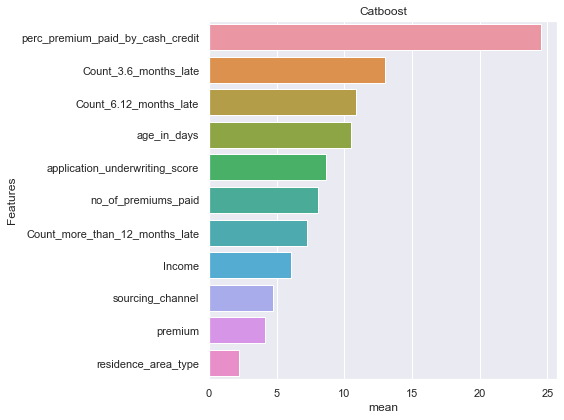

In [21]:
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Features", data=tmp_df.sort_values(by="mean", ascending=False))
plt.title('Catboost')
plt.tight_layout()
plt.show()

### Applying the model on test dataframe

In [22]:
result = model.predict(df_test)

In [23]:
result = pd.DataFrame(result)
result.head()

,0
0,1
1,1
2,1
3,1
4,1


In [24]:
result.to_csv('catboost_single_model.csv',  header=False, index=False)

## Training multiple models by cross-validation and save each model separately

The goal here is to save each model trained by one fold of cross-validation seperately on disk and use them as an emsemble to predict test data set.

In [25]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
i = 1
models = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
        
    models.append(model)
    # save the model to disk
    model_name = 'model_' + str(i) + '.sav'
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        print('Model {} saved as {}.'.format(i, model_name))
    i+=1
    
#     pickle.dump(model, model_name)
#     pickle.dump(model, open(model_name, 'wb'))

Model 1 saved as model_1.sav.
Model 2 saved as model_2.sav.
Model 3 saved as model_3.sav.
Model 4 saved as model_4.sav.
Model 5 saved as model_5.sav.


**Loading a sample model and check on test feature matrix**

In [26]:
# load the model from disk
filename = 'model_1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9495632572555649


In [27]:
pred = loaded_model.predict(X_test)
print(f1_score(y_test, pred, pos_label=0))

0.3106546854942233


#### Loading each seperate model and use their average for prediction

Final prediction is the majority vote of all models

In [28]:
model_list = ['model_1.sav', 'model_2.sav', 'model_3.sav', 'model_4.sav', 'model_5.sav']
result_set = []
for model in model_list:
    loaded_model = pickle.load(open(model, 'rb'))
    res = loaded_model.predict(df_test)
    result_set.append(res)

In [29]:
len(result_set)

5

In [30]:
result_set[0]

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [31]:
result_df = pd.DataFrame(result_set)
result_df = result_df.T
result_df.head()

,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


In [32]:
ensemble_res = result_df.mean(axis=1)
ensemble_res

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
26612    1.0
26613    0.0
26614    1.0
26615    1.0
26616    1.0
Length: 26617, dtype: float64

In [33]:
final_vote = ensemble_res.apply(lambda x: [0 if x<0.5 else 1])
final_vote
# df1['A'].apply(lambda x: [y if y <= 9 else 11 for y in x])

0        [1]
1        [1]
2        [1]
3        [1]
4        [1]
        ... 
26612    [1]
26613    [0]
26614    [1]
26615    [1]
26616    [1]
Length: 26617, dtype: object

In [34]:
final_vote_tmp = final_vote.values.tolist()
type(final_vote_tmp)

list

In [35]:
# final_vote_tmp

In [47]:
# [list(x) for x in zip(*final_vote_tmp)]
# [list(x) for x in zip(*final_vote_tmp)][0]

In [37]:
len([list(x) for x in zip(*final_vote_tmp)][0])

26617

In [38]:
ensemble_vote = pd.DataFrame({'predicted_value': [list(x) for x in zip(*final_vote_tmp)][0]})
ensemble_vote.head()

,predicted_value
0,1
1,1
2,1
3,1
4,1


In [39]:
ensemble_vote.to_csv('ensemble_vote.csv', header=False, index=False)

### Labeling categorical parameters

+ Catboost can handle categorical data and therefore, does not require labeling. In this section we check if transforming categorical parameters to numerical values can have an impact on model accuracy. 
+ sourcing_channel and residence_area_type are categorical data types in this data set.

In [40]:
for col in df_train.columns:
    le = LabelEncoder()
    if df_train[col].dtype == 'object':
        df_train[col] = le.fit_transform(df_train[col]) 
        df_test[col] = le.transform(df_test[col])

df_train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,2,1,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,2,0,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,0,1,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,1,1,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,1,1,7500,1


In [52]:
X = df_train.drop('renewal', axis=1)
y = df_train['renewal']
X.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,2,1,3300
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,2,0,3300
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,0,1,9600
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,1,1,9600
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,1,1,7500


In [53]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: renewal, dtype: int64

### Training a catboost model with whole train data

In [58]:
model_le = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, verbose=100 ,cat_features=cat_features)
model_le.fit(X, y, verbose=True, early_stopping_rounds=100) # use_best_model=True can only be used with nonempty eval_set.

0:	learn: 0.5602626	total: 61.2ms	remaining: 2m 2s
1:	learn: 0.4671929	total: 124ms	remaining: 2m 4s
2:	learn: 0.3932735	total: 192ms	remaining: 2m 7s
3:	learn: 0.3401845	total: 259ms	remaining: 2m 9s
4:	learn: 0.3018050	total: 324ms	remaining: 2m 9s
5:	learn: 0.2723198	total: 388ms	remaining: 2m 9s
6:	learn: 0.2498644	total: 450ms	remaining: 2m 8s
7:	learn: 0.2342971	total: 516ms	remaining: 2m 8s
8:	learn: 0.2228799	total: 581ms	remaining: 2m 8s
9:	learn: 0.2135726	total: 645ms	remaining: 2m 8s
10:	learn: 0.2062990	total: 713ms	remaining: 2m 8s
11:	learn: 0.2001405	total: 780ms	remaining: 2m 9s
12:	learn: 0.1954228	total: 846ms	remaining: 2m 9s
13:	learn: 0.1919629	total: 910ms	remaining: 2m 9s
14:	learn: 0.1890781	total: 982ms	remaining: 2m 9s
15:	learn: 0.1871910	total: 1.05s	remaining: 2m 10s
16:	learn: 0.1855151	total: 1.12s	remaining: 2m 10s
17:	learn: 0.1837015	total: 1.19s	remaining: 2m 10s
18:	learn: 0.1820546	total: 1.25s	remaining: 2m 10s
19:	learn: 0.1806860	total: 1.32s	re

165:	learn: 0.1518518	total: 10.9s	remaining: 2m
166:	learn: 0.1518001	total: 10.9s	remaining: 2m
167:	learn: 0.1516054	total: 11s	remaining: 2m
168:	learn: 0.1515252	total: 11.1s	remaining: 2m
169:	learn: 0.1513760	total: 11.2s	remaining: 2m
170:	learn: 0.1513058	total: 11.2s	remaining: 1m 59s
171:	learn: 0.1512048	total: 11.3s	remaining: 1m 59s
172:	learn: 0.1510783	total: 11.3s	remaining: 1m 59s
173:	learn: 0.1509481	total: 11.4s	remaining: 1m 59s
174:	learn: 0.1508744	total: 11.5s	remaining: 1m 59s
175:	learn: 0.1506861	total: 11.5s	remaining: 1m 59s
176:	learn: 0.1504302	total: 11.6s	remaining: 1m 59s
177:	learn: 0.1503359	total: 11.7s	remaining: 1m 59s
178:	learn: 0.1501948	total: 11.7s	remaining: 1m 59s
179:	learn: 0.1500813	total: 11.8s	remaining: 1m 59s
180:	learn: 0.1499962	total: 11.9s	remaining: 1m 59s
181:	learn: 0.1499414	total: 11.9s	remaining: 1m 59s
182:	learn: 0.1499047	total: 12s	remaining: 1m 58s
183:	learn: 0.1498326	total: 12.1s	remaining: 1m 58s
184:	learn: 0.149

328:	learn: 0.1326901	total: 22.9s	remaining: 1m 56s
329:	learn: 0.1325732	total: 22.9s	remaining: 1m 56s
330:	learn: 0.1324139	total: 23s	remaining: 1m 55s
331:	learn: 0.1323368	total: 23.1s	remaining: 1m 55s
332:	learn: 0.1322717	total: 23.1s	remaining: 1m 55s
333:	learn: 0.1321127	total: 23.2s	remaining: 1m 55s
334:	learn: 0.1319975	total: 23.3s	remaining: 1m 55s
335:	learn: 0.1318198	total: 23.4s	remaining: 1m 55s
336:	learn: 0.1317279	total: 23.4s	remaining: 1m 55s
337:	learn: 0.1316594	total: 23.5s	remaining: 1m 55s
338:	learn: 0.1314611	total: 23.6s	remaining: 1m 55s
339:	learn: 0.1313663	total: 23.6s	remaining: 1m 55s
340:	learn: 0.1313254	total: 23.7s	remaining: 1m 55s
341:	learn: 0.1312670	total: 23.8s	remaining: 1m 55s
342:	learn: 0.1311728	total: 23.8s	remaining: 1m 55s
343:	learn: 0.1310266	total: 23.9s	remaining: 1m 55s
344:	learn: 0.1309207	total: 24s	remaining: 1m 54s
345:	learn: 0.1308417	total: 24s	remaining: 1m 54s
346:	learn: 0.1307507	total: 24.1s	remaining: 1m 54s

486:	learn: 0.1183995	total: 34.2s	remaining: 1m 46s
487:	learn: 0.1182910	total: 34.3s	remaining: 1m 46s
488:	learn: 0.1182725	total: 34.4s	remaining: 1m 46s
489:	learn: 0.1181887	total: 34.4s	remaining: 1m 46s
490:	learn: 0.1181136	total: 34.5s	remaining: 1m 46s
491:	learn: 0.1179806	total: 34.6s	remaining: 1m 45s
492:	learn: 0.1178959	total: 34.7s	remaining: 1m 45s
493:	learn: 0.1178237	total: 34.7s	remaining: 1m 45s
494:	learn: 0.1177422	total: 34.8s	remaining: 1m 45s
495:	learn: 0.1176215	total: 34.9s	remaining: 1m 45s
496:	learn: 0.1175900	total: 34.9s	remaining: 1m 45s
497:	learn: 0.1174697	total: 35s	remaining: 1m 45s
498:	learn: 0.1174488	total: 35.1s	remaining: 1m 45s
499:	learn: 0.1174093	total: 35.1s	remaining: 1m 45s
500:	learn: 0.1173263	total: 35.2s	remaining: 1m 45s
501:	learn: 0.1171974	total: 35.3s	remaining: 1m 45s
502:	learn: 0.1171028	total: 35.4s	remaining: 1m 45s
503:	learn: 0.1169238	total: 35.4s	remaining: 1m 45s
504:	learn: 0.1168480	total: 35.5s	remaining: 1m

643:	learn: 0.1058646	total: 47.7s	remaining: 1m 40s
644:	learn: 0.1058300	total: 47.8s	remaining: 1m 40s
645:	learn: 0.1057370	total: 47.9s	remaining: 1m 40s
646:	learn: 0.1056598	total: 48s	remaining: 1m 40s
647:	learn: 0.1055373	total: 48s	remaining: 1m 40s
648:	learn: 0.1054795	total: 48.1s	remaining: 1m 40s
649:	learn: 0.1054000	total: 48.2s	remaining: 1m 40s
650:	learn: 0.1053357	total: 48.2s	remaining: 1m 39s
651:	learn: 0.1052818	total: 48.3s	remaining: 1m 39s
652:	learn: 0.1052615	total: 48.4s	remaining: 1m 39s
653:	learn: 0.1052535	total: 48.4s	remaining: 1m 39s
654:	learn: 0.1052033	total: 48.5s	remaining: 1m 39s
655:	learn: 0.1050934	total: 48.6s	remaining: 1m 39s
656:	learn: 0.1050146	total: 48.7s	remaining: 1m 39s
657:	learn: 0.1048925	total: 48.8s	remaining: 1m 39s
658:	learn: 0.1048377	total: 48.9s	remaining: 1m 39s
659:	learn: 0.1047857	total: 48.9s	remaining: 1m 39s
660:	learn: 0.1047574	total: 49s	remaining: 1m 39s
661:	learn: 0.1045854	total: 49.1s	remaining: 1m 39s

799:	learn: 0.0962267	total: 59.1s	remaining: 1m 28s
800:	learn: 0.0961603	total: 59.2s	remaining: 1m 28s
801:	learn: 0.0961169	total: 59.3s	remaining: 1m 28s
802:	learn: 0.0960750	total: 59.4s	remaining: 1m 28s
803:	learn: 0.0960173	total: 59.4s	remaining: 1m 28s
804:	learn: 0.0959462	total: 59.6s	remaining: 1m 28s
805:	learn: 0.0959116	total: 59.8s	remaining: 1m 28s
806:	learn: 0.0958654	total: 59.9s	remaining: 1m 28s
807:	learn: 0.0958050	total: 60s	remaining: 1m 28s
808:	learn: 0.0957560	total: 1m	remaining: 1m 28s
809:	learn: 0.0957106	total: 1m	remaining: 1m 28s
810:	learn: 0.0955986	total: 1m	remaining: 1m 28s
811:	learn: 0.0955112	total: 1m	remaining: 1m 28s
812:	learn: 0.0954360	total: 1m	remaining: 1m 28s
813:	learn: 0.0953114	total: 1m	remaining: 1m 28s
814:	learn: 0.0952238	total: 1m	remaining: 1m 28s
815:	learn: 0.0951777	total: 1m	remaining: 1m 28s
816:	learn: 0.0951549	total: 1m	remaining: 1m 28s
817:	learn: 0.0950742	total: 1m	remaining: 1m 28s
818:	learn: 0.0950424	tot

954:	learn: 0.0877319	total: 1m 11s	remaining: 1m 18s
955:	learn: 0.0876841	total: 1m 11s	remaining: 1m 18s
956:	learn: 0.0875977	total: 1m 11s	remaining: 1m 18s
957:	learn: 0.0875817	total: 1m 11s	remaining: 1m 17s
958:	learn: 0.0875484	total: 1m 11s	remaining: 1m 17s
959:	learn: 0.0874911	total: 1m 11s	remaining: 1m 17s
960:	learn: 0.0874587	total: 1m 11s	remaining: 1m 17s
961:	learn: 0.0874199	total: 1m 11s	remaining: 1m 17s
962:	learn: 0.0873601	total: 1m 12s	remaining: 1m 17s
963:	learn: 0.0873279	total: 1m 12s	remaining: 1m 17s
964:	learn: 0.0872604	total: 1m 12s	remaining: 1m 17s
965:	learn: 0.0872041	total: 1m 12s	remaining: 1m 17s
966:	learn: 0.0871681	total: 1m 12s	remaining: 1m 17s
967:	learn: 0.0870609	total: 1m 12s	remaining: 1m 17s
968:	learn: 0.0870187	total: 1m 12s	remaining: 1m 17s
969:	learn: 0.0869655	total: 1m 12s	remaining: 1m 17s
970:	learn: 0.0868953	total: 1m 12s	remaining: 1m 17s
971:	learn: 0.0868660	total: 1m 12s	remaining: 1m 16s
972:	learn: 0.0868097	total:

1107:	learn: 0.0801344	total: 1m 24s	remaining: 1m 8s
1108:	learn: 0.0801085	total: 1m 24s	remaining: 1m 8s
1109:	learn: 0.0800457	total: 1m 25s	remaining: 1m 8s
1110:	learn: 0.0800060	total: 1m 25s	remaining: 1m 8s
1111:	learn: 0.0799679	total: 1m 25s	remaining: 1m 8s
1112:	learn: 0.0799460	total: 1m 25s	remaining: 1m 7s
1113:	learn: 0.0799046	total: 1m 25s	remaining: 1m 7s
1114:	learn: 0.0798818	total: 1m 25s	remaining: 1m 7s
1115:	learn: 0.0797916	total: 1m 25s	remaining: 1m 7s
1116:	learn: 0.0797137	total: 1m 25s	remaining: 1m 7s
1117:	learn: 0.0796323	total: 1m 25s	remaining: 1m 7s
1118:	learn: 0.0796045	total: 1m 25s	remaining: 1m 7s
1119:	learn: 0.0795242	total: 1m 25s	remaining: 1m 7s
1120:	learn: 0.0794526	total: 1m 25s	remaining: 1m 7s
1121:	learn: 0.0793797	total: 1m 25s	remaining: 1m 7s
1122:	learn: 0.0793312	total: 1m 26s	remaining: 1m 7s
1123:	learn: 0.0792794	total: 1m 26s	remaining: 1m 7s
1124:	learn: 0.0791967	total: 1m 26s	remaining: 1m 7s
1125:	learn: 0.0791431	total

1260:	learn: 0.0732388	total: 1m 37s	remaining: 57.3s
1261:	learn: 0.0732034	total: 1m 37s	remaining: 57.2s
1262:	learn: 0.0730822	total: 1m 37s	remaining: 57.1s
1263:	learn: 0.0730453	total: 1m 37s	remaining: 57.1s
1264:	learn: 0.0729983	total: 1m 38s	remaining: 57s
1265:	learn: 0.0729630	total: 1m 38s	remaining: 56.9s
1266:	learn: 0.0729295	total: 1m 38s	remaining: 56.8s
1267:	learn: 0.0729177	total: 1m 38s	remaining: 56.7s
1268:	learn: 0.0728611	total: 1m 38s	remaining: 56.7s
1269:	learn: 0.0728003	total: 1m 38s	remaining: 56.6s
1270:	learn: 0.0727601	total: 1m 38s	remaining: 56.5s
1271:	learn: 0.0727288	total: 1m 38s	remaining: 56.4s
1272:	learn: 0.0726531	total: 1m 38s	remaining: 56.3s
1273:	learn: 0.0726253	total: 1m 38s	remaining: 56.3s
1274:	learn: 0.0725968	total: 1m 38s	remaining: 56.2s
1275:	learn: 0.0725579	total: 1m 38s	remaining: 56.1s
1276:	learn: 0.0725118	total: 1m 38s	remaining: 56s
1277:	learn: 0.0724810	total: 1m 39s	remaining: 55.9s
1278:	learn: 0.0724215	total: 1m

1414:	learn: 0.0668273	total: 1m 49s	remaining: 45.5s
1415:	learn: 0.0667921	total: 1m 50s	remaining: 45.4s
1416:	learn: 0.0667490	total: 1m 50s	remaining: 45.3s
1417:	learn: 0.0666718	total: 1m 50s	remaining: 45.2s
1418:	learn: 0.0666236	total: 1m 50s	remaining: 45.1s
1419:	learn: 0.0665668	total: 1m 50s	remaining: 45.1s
1420:	learn: 0.0665135	total: 1m 50s	remaining: 45s
1421:	learn: 0.0664826	total: 1m 50s	remaining: 44.9s
1422:	learn: 0.0664293	total: 1m 50s	remaining: 44.9s
1423:	learn: 0.0664103	total: 1m 50s	remaining: 44.8s
1424:	learn: 0.0663656	total: 1m 50s	remaining: 44.7s
1425:	learn: 0.0663446	total: 1m 50s	remaining: 44.6s
1426:	learn: 0.0662976	total: 1m 50s	remaining: 44.5s
1427:	learn: 0.0662705	total: 1m 50s	remaining: 44.5s
1428:	learn: 0.0662495	total: 1m 51s	remaining: 44.4s
1429:	learn: 0.0661946	total: 1m 51s	remaining: 44.3s
1430:	learn: 0.0661652	total: 1m 51s	remaining: 44.2s
1431:	learn: 0.0661263	total: 1m 51s	remaining: 44.1s
1432:	learn: 0.0660978	total: 

1568:	learn: 0.0614019	total: 2m 1s	remaining: 33.4s
1569:	learn: 0.0613602	total: 2m 1s	remaining: 33.3s
1570:	learn: 0.0613010	total: 2m 1s	remaining: 33.2s
1571:	learn: 0.0612309	total: 2m 1s	remaining: 33.2s
1572:	learn: 0.0611940	total: 2m 1s	remaining: 33.1s
1573:	learn: 0.0611509	total: 2m 1s	remaining: 33s
1574:	learn: 0.0611082	total: 2m 2s	remaining: 32.9s
1575:	learn: 0.0610909	total: 2m 2s	remaining: 32.9s
1576:	learn: 0.0610484	total: 2m 2s	remaining: 32.8s
1577:	learn: 0.0610273	total: 2m 2s	remaining: 32.7s
1578:	learn: 0.0610066	total: 2m 2s	remaining: 32.6s
1579:	learn: 0.0609551	total: 2m 2s	remaining: 32.6s
1580:	learn: 0.0609183	total: 2m 2s	remaining: 32.5s
1581:	learn: 0.0608964	total: 2m 2s	remaining: 32.4s
1582:	learn: 0.0608679	total: 2m 2s	remaining: 32.3s
1583:	learn: 0.0607825	total: 2m 2s	remaining: 32.2s
1584:	learn: 0.0607552	total: 2m 2s	remaining: 32.2s
1585:	learn: 0.0606957	total: 2m 2s	remaining: 32.1s
1586:	learn: 0.0606319	total: 2m 3s	remaining: 3

1723:	learn: 0.0563921	total: 2m 13s	remaining: 21.4s
1724:	learn: 0.0563788	total: 2m 14s	remaining: 21.4s
1725:	learn: 0.0563528	total: 2m 14s	remaining: 21.3s
1726:	learn: 0.0563280	total: 2m 14s	remaining: 21.2s
1727:	learn: 0.0563094	total: 2m 14s	remaining: 21.2s
1728:	learn: 0.0562310	total: 2m 14s	remaining: 21.1s
1729:	learn: 0.0562252	total: 2m 14s	remaining: 21s
1730:	learn: 0.0561769	total: 2m 14s	remaining: 20.9s
1731:	learn: 0.0561439	total: 2m 14s	remaining: 20.9s
1732:	learn: 0.0561168	total: 2m 14s	remaining: 20.8s
1733:	learn: 0.0560811	total: 2m 15s	remaining: 20.7s
1734:	learn: 0.0560558	total: 2m 15s	remaining: 20.6s
1735:	learn: 0.0560177	total: 2m 15s	remaining: 20.6s
1736:	learn: 0.0559938	total: 2m 15s	remaining: 20.5s
1737:	learn: 0.0559700	total: 2m 15s	remaining: 20.4s
1738:	learn: 0.0559390	total: 2m 15s	remaining: 20.3s
1739:	learn: 0.0559134	total: 2m 15s	remaining: 20.2s
1740:	learn: 0.0558906	total: 2m 15s	remaining: 20.2s
1741:	learn: 0.0558741	total: 

1878:	learn: 0.0518600	total: 2m 25s	remaining: 9.38s
1879:	learn: 0.0518491	total: 2m 25s	remaining: 9.31s
1880:	learn: 0.0518222	total: 2m 25s	remaining: 9.23s
1881:	learn: 0.0517801	total: 2m 25s	remaining: 9.15s
1882:	learn: 0.0517390	total: 2m 26s	remaining: 9.07s
1883:	learn: 0.0517016	total: 2m 26s	remaining: 9s
1884:	learn: 0.0516811	total: 2m 26s	remaining: 8.92s
1885:	learn: 0.0516810	total: 2m 26s	remaining: 8.84s
1886:	learn: 0.0516472	total: 2m 26s	remaining: 8.76s
1887:	learn: 0.0516145	total: 2m 26s	remaining: 8.68s
1888:	learn: 0.0515761	total: 2m 26s	remaining: 8.61s
1889:	learn: 0.0515506	total: 2m 26s	remaining: 8.53s
1890:	learn: 0.0515344	total: 2m 26s	remaining: 8.45s
1891:	learn: 0.0515169	total: 2m 26s	remaining: 8.37s
1892:	learn: 0.0514954	total: 2m 26s	remaining: 8.29s
1893:	learn: 0.0514803	total: 2m 26s	remaining: 8.22s
1894:	learn: 0.0514556	total: 2m 26s	remaining: 8.14s
1895:	learn: 0.0514505	total: 2m 26s	remaining: 8.06s
1896:	learn: 0.0514404	total: 2

In [55]:
res_le = model_le.predict(df_test)
res_le

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [57]:
res_le_df = pd.DataFrame(res_le)
res_le_df.to_csv('catboost_with_labelencoding.csv', header=False, index=False)
res_le_df.head()

,0
0,1
1,1
2,1
3,1
4,1
